# Matrix Factorization Visualizations - Method 2 (Code Modified from Homework 5)
Starter code written by: Fabian Boemer, Sid Murching, Suraj Nair, Alex Cui

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
def grad_U(Ui, Yij, Vj, mu, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), the average of all observations mu, 
    ai (the ith entry of a), bj (the jth entry of b), 
    reg (the regularization parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    grad = reg*Ui - Vj*((Yij - mu) - (np.dot(Ui, Vj) + ai + bj))
    
    return eta*grad   

def grad_V(Vj, Yij, Ui, mu, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    the average of all observations mu, ai (the ith entry of a), 
    bj (the jth entry of b), Ui (the ith row of U), 
    reg (the regularization parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    
    grad = reg*Vj - Ui*((Yij - mu) - (np.dot(Ui, Vj) + ai + bj))
    
    return eta*grad  

def grad_a(ai, Yij, mu, Ui, Vj, bj, reg, eta):
    """
    Takes as input ai (the ith entry of a), a training point Yij, 
    Ui (the ith row of U), the average of all observations mu, 
    the column vector Vj (jth column of V^T), bj (the jth entry of b),
    reg (the regularization parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to ai multiplied by eta.
    """
    
    grad = reg*ai - (Yij - mu) + (np.dot(Ui, Vj) + ai + bj)
    
    return eta*grad

def grad_b(bj, Yij, mu, Ui, Vj, ai, reg, eta):
    """
    Takes as input bj (the jth entry of b), a training point Yij, 
    Ui (the ith row of U), the average of all observations mu, 
    the column vector Vj (jth column of V^T), ai (the ith entry of a),
    reg (the regularization parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to bj multiplied by eta.
    """
    
    grad = reg*bj - (Yij - mu) + (np.dot(Ui, Vj) + ai + bj)
    
    return eta*grad

def get_err(U, V, Y, a, b, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j;
    user/movie matrices U and V; bias vectors a and b; 
    and mu, the average of all observations.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
        
    error = 0.5*reg*(np.linalg.norm(U, 'fro')**2 + np.linalg.norm(V, 'fro')**2 + np.linalg.norm(a)**2 + np.linalg.norm(b)**2)

    for k in range(len(Y)):
        Yij = Y[k][2]
        i = Y[k][0] - 1
        j = Y[k][1] - 1
        error += 0.5*((Yij - mu) - (np.dot(U[i,:], V[j,:]) + a[i] + b[j]))**2

    return error / len(Y) # mean error

def train_model(M, N, K, eta, reg, Y, mu, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, and mu is the average of all Y_ij,
    learns an M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    # initialize entries of U, V, a, b uniformly and randomly in [-0.5, 0.5]
    U = np.random.rand(M, K) - 0.5*np.ones([M, K])
    V = np.random.rand(N, K) - 0.5*np.ones([N, K])
    a = np.random.rand(M, 1) - 0.5*np.ones([M, 1]) # corresponds to users
    b = np.random.rand(N, 1) - 0.5*np.ones([N, 1]) # corresponds to movies
    
    epochs = 0
    rel_red = np.inf
    err = get_err(U, V, Y, a, b, mu)
    
    while epochs < max_epochs and rel_red > eps:
        # store previous error
        prev_err = np.copy(err)
        
        # shuffle training data 
        order = np.random.permutation(len(Y))
        
        # perform SGD
        for o in order:
            i = Y[o][0] - 1
            j = Y[o][1] - 1
            Yij = Y[o][2]
            Ui = U[i,:]
            Vj = V[j,:]
            ai = a[i]
            bj = b[j]
            
            
            # update U, V, a, b
            U[i,:] -= grad_U(Ui, Yij, Vj, mu, ai, bj, reg, eta)
            V[j,:] -= grad_V(Vj, Yij, Ui, mu, ai, bj, reg, eta)
            a[i] -= grad_a(ai, Yij, mu, Ui, Vj, bj, reg, eta) 
            b[j] -= grad_b(bj, Yij, mu, Ui, Vj, ai, reg, eta)
            
            
        # compute error and loss reduction
        err = get_err(U, V, Y, a, b, mu)
        loss_red = err - prev_err
        
        # store initial loss reduction for comparison
        if epochs == 0:
            init_red = np.copy(loss_red)
        
        # compute relative loss reduction
        rel_red = loss_red/init_red
        epochs += 1
        print(epochs)
    
    return (U, V, err, a, b)

In [48]:
# factorize using SGD as in Homework 5
Y_train = np.loadtxt('./data/train2.txt').astype(int)
Y_test = np.loadtxt('./data/test2.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20
mu = np.mean(Y_train[:,2])

regs = [10**-4, 10**-3, 10**-2, 10**-1, 0.3, 0.5, 0.7, 1]
eta = 0.03 # learning rate
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
    U, V, e_in, a, b = train_model(M, N, k, eta, reg, Y_train, mu)
    e_out = get_err(U, V, Y_test, a, b, mu)

    E_ins.append(e_in)
    E_outs.append(e_out)

Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.0001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.01
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.3
1
2
3
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.5
1
2
3
4
5
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 0.7
1
2
3
4
5
6
Training model with M = 943, N = 1664, k = 20, eta = 0.03, reg = 1
1
2
3
4


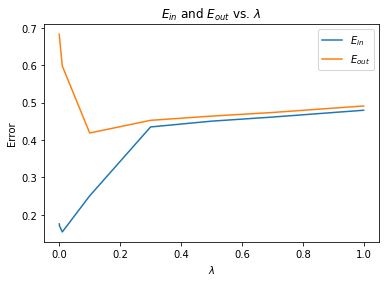

In [4]:
# Plot values of E_in across k for each value of lambda
plt.figure()
plt.plot(regs, E_ins)
plt.plot(regs, E_outs)
plt.title('$E_{in}$ and $E_{out}$ vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend(['$E_{in}$', '$E_{out}$'])
plt.savefig('matrix_2_reg.png')

In [177]:
# train using best lambda
U, V, e_in, a, b = train_model(M, N, k, eta, 0.1, Y_train, mu)
e_out = get_err(U, V, Y_test, a, b, mu)

# note that U is Mxk and V is Nxk, so we transpose them to be consistent
# with the convention used in the Miniproject 2 pdf
U = U.T
V = V.T

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [178]:
e_out

array([0.41739962])

In [179]:
# mean-centering 
V_mean = V.mean(axis=1)
for i in range(N):
    V[:,i] -= V_mean
for i in range(M):
    U[:,i] -= V_mean

# get SVD of V
A, S, B = np.linalg.svd(V)

In [180]:
# project U, V into K-dimensional space
K = 2
U_tilde = np.matmul(A.T[:K], U)
V_tilde = np.matmul(A.T[:K], V)

In [181]:
# load data from cleaned files
movies = pd.read_csv('data/movies.csv')
data = pd.read_csv('data/data.csv')

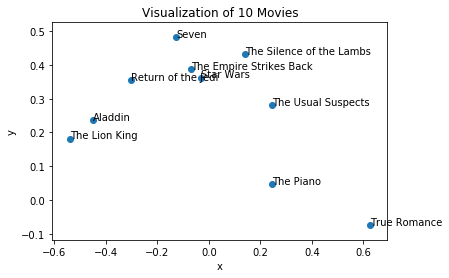

In [182]:
# visualize any 10 movies
ids = [11, 12, 71, 95, 98, 92, 578, 181, 172, 50]

titles = ['Seven', 'The Usual Suspects', 'The Lion King', 'Aladdin', 'The Silence of the Lambs', 'True Romance', 'The Piano', 'Return of the Jedi', 'The Empire Strikes Back', 'Star Wars']   
    
x = [0]*10
y = [0]*10
for i in range(len(ids)):
    x[i] = V_tilde[0][ids[i]-1]
    y[i] = V_tilde[1][ids[i]-1]

fig, ax = plt.subplots()
plt.scatter(x, y)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_a.png')

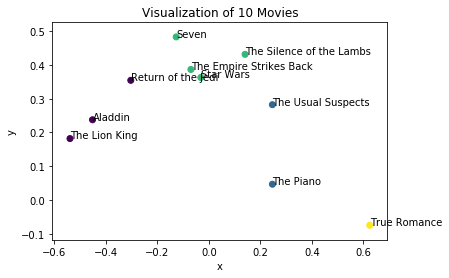

In [183]:
# run k-means to cluster points
from sklearn.cluster import KMeans

X = np.column_stack((x, y))
labels = KMeans(n_clusters=4, random_state=0).fit_predict(X)

fig, ax = plt.subplots()
plt.scatter(x, y, c=labels)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_a_clusters.png')

49    Star Wars (1977)
Name: Title, dtype: object
257    Contact (1997)
Name: Title, dtype: object
99    Fargo (1996)
Name: Title, dtype: object
180    Return of the Jedi (1983)
Name: Title, dtype: object
292    Liar Liar (1997)
Name: Title, dtype: object
284    English Patient, The (1996)
Name: Title, dtype: object
286    Scream (1996)
Name: Title, dtype: object
0    Toy Story (1995)
Name: Title, dtype: object
298    Air Force One (1997)
Name: Title, dtype: object
120    Independence Day (ID4) (1996)
Name: Title, dtype: object


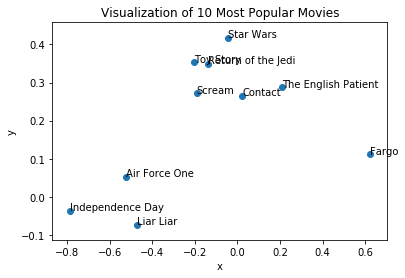

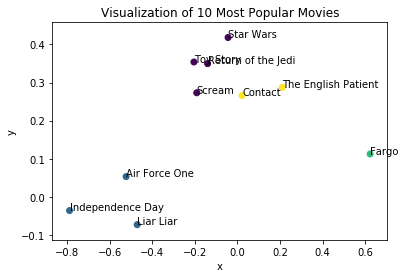

In [172]:
# visualize 10 most popular movies
pop = data['Movie'].value_counts().head(10).index

for i in pop:
    print(movies[movies['ID'] == i]['Title'])
    
titles = ['Star Wars', 'Contact', 'Fargo', 'Return of the Jedi', 'Liar Liar', 'The English Patient', 'Scream', 'Toy Story', 'Air Force One', 'Independence Day']   
    
x = [0]*10
y = [0]*10
for i in range(len(pop)):
    x[i] = V_tilde[0][pop[i]-1]
    y[i] = V_tilde[1][pop[i]-1]

# clustering
X = np.column_stack((x, y))
labels = KMeans(n_clusters=4, random_state=0).fit_predict(X)

# plot visualization
fig, ax = plt.subplots()
plt.scatter(x, y)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Most Popular Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_b.png')

# plot clusters
fig, ax = plt.subplots()
plt.scatter(x, y, c=labels)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Most Popular Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_b_clusters.png')

1588    Someone Else's America (1995)
Name: Title, dtype: object
1179    Prefontaine (1997)
Name: Title, dtype: object
1525    Aiqing wansui (1994)
Name: Title, dtype: object
1282    Star Kid (1997)
Name: Title, dtype: object
1637    Entertaining Angels: The Dorothy Day Story (1996)
Name: Title, dtype: object
1112    They Made Me a Criminal (1939)
Name: Title, dtype: object
1191    Marlene Dietrich: Shadow and Light (1996) 
Name: Title, dtype: object
807    Great Day in Harlem, A (1994)
Name: Title, dtype: object
1456    Saint of Fort Washington, The (1993)
Name: Title, dtype: object
1489    Santa with Muscles (1996)
Name: Title, dtype: object


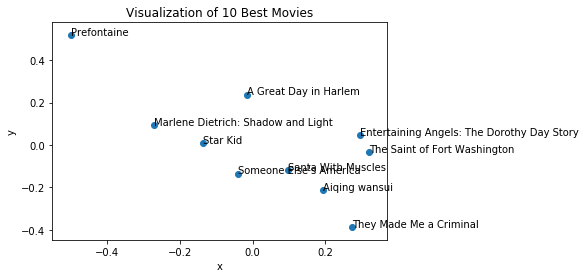

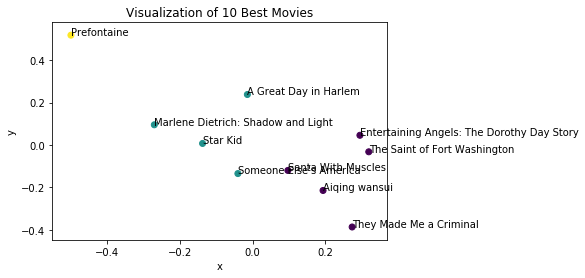

In [173]:
# visualize 10 best movies
sorted_df = movies.sort_values(by='avg_rating', ascending=False)
best = sorted_df.head(10)['ID']

for i in best:
    print(movies[movies['ID'] == i]['Title'])
    
titles = ["Someone Else's America", 'Prefontaine', 'Aiqing wansui', 'Star Kid', 'Entertaining Angels: The Dorothy Day Story', 'They Made Me a Criminal', 'Marlene Dietrich: Shadow and Light', 'A Great Day in Harlem', 'The Saint of Fort Washington', 'Santa With Muscles']   
    
x = [0]*10
y = [0]*10
count = 0
for i in best:
    x[count] = V_tilde[0][i-1]
    y[count] = V_tilde[1][i-1]
    count += 1

# clustering
X = np.column_stack((x, y))
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X)

# plot visualization
fig, ax = plt.subplots()
plt.scatter(x, y)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Best Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_c.png')

# plot clusters
fig, ax = plt.subplots()
plt.scatter(x, y, c=labels)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Best Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_c_clusters.png')

0    Toy Story (1995)
Name: Title, dtype: object
70    Lion King, The (1994)
Name: Title, dtype: object
94    Aladdin (1992)
Name: Title, dtype: object
98    Snow White and the Seven Dwarfs (1937)
Name: Title, dtype: object
100    Heavy Metal (1981)
Name: Title, dtype: object
101    Aristocats, The (1970)
Name: Title, dtype: object
102    All Dogs Go to Heaven 2 (1996)
Name: Title, dtype: object
113    Wallace & Gromit: The Best of Aardman Animatio...
Name: Title, dtype: object
168    Wrong Trousers, The (1993)
Name: Title, dtype: object
188    Grand Day Out, A (1992)
Name: Title, dtype: object


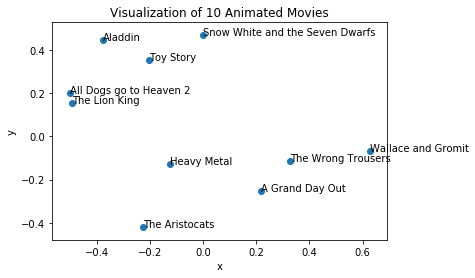

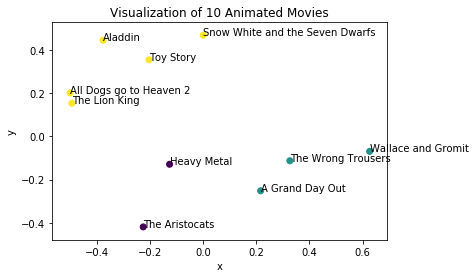

In [174]:
# Visualize 10 animated movies
# get all animated movies 
animated = movies[movies['Animation'] == 1]['ID'].head(10)

for i in animated:
    print(movies[movies['ID'] == i]['Title'])
    
titles = ['Toy Story', 'The Lion King', 'Aladdin', 'Snow White and the Seven Dwarfs', 'Heavy Metal', 'The Aristocats', 'All Dogs go to Heaven 2', 'Wallace and Gromit', 'The Wrong Trousers', 'A Grand Day Out']   
    
x = [0]*10
y = [0]*10
count = 0

for i in animated:
    x[count] = V_tilde[0][i-1]
    y[count] = V_tilde[1][i-1]
    count += 1
    
# clustering
X = np.column_stack((x, y))
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X)

# plot visualization
fig, ax = plt.subplots()
plt.scatter(x, y)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Animated Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_d_1.png')

# plot clusters
fig, ax = plt.subplots()
plt.scatter(x, y, c=labels)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Animated Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_d_1_clusters.png')

50    Legends of the Fall (1994)
Name: Title, dtype: object
72    Maverick (1994)
Name: Title, dtype: object
96    Dances with Wolves (1990)
Name: Title, dtype: object
176    Good, The Bad and The Ugly, The (1966)
Name: Title, dtype: object
202    Unforgiven (1992)
Name: Title, dtype: object
231    Young Guns (1988)
Name: Title, dtype: object
411    Apple Dumpling Gang, The (1975)
Name: Title, dtype: object
431    Butch Cassidy and the Sundance Kid (1969)
Name: Title, dtype: object
466    Tombstone (1993)
Name: Title, dtype: object
505    Magnificent Seven, The (1954)
Name: Title, dtype: object


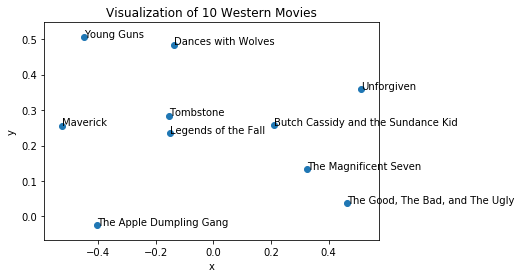

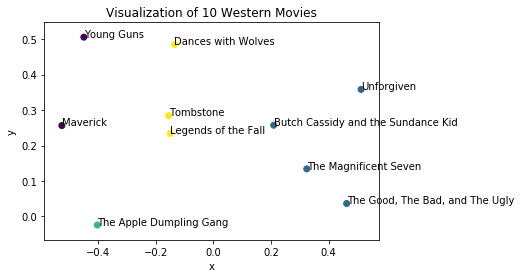

In [175]:
# Visualize 10 Western movies
# get all Western movies 
western = movies[movies['Western'] == 1]['ID'].head(10)

for i in western:
    print(movies[movies['ID'] == i]['Title'])
    
titles = ['Legends of the Fall', 'Maverick', 'Dances with Wolves', 'The Good, The Bad, and The Ugly', 'Unforgiven', 'Young Guns', 'The Apple Dumpling Gang', 'Butch Cassidy and the Sundance Kid', 'Tombstone', 'The Magnificent Seven']   
    
x = [0]*10
y = [0]*10
count = 0

for i in western:
    x[count] = V_tilde[0][i-1]
    y[count] = V_tilde[1][i-1]
    count += 1

# clustering
X = np.column_stack((x, y))
labels = KMeans(n_clusters=4, random_state=0).fit_predict(X)

# plot visualization
fig, ax = plt.subplots()
plt.scatter(x, y)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Western Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_d_2.png')

# plot clusters
fig, ax = plt.subplots()
plt.scatter(x, y, c=labels)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Western Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_2_d_2_clusters.png')

16    From Dusk Till Dawn (1996)
Name: Title, dtype: object
83    Robert A. Heinlein's The Puppet Masters (1994)
Name: Title, dtype: object
100    Heavy Metal (1981)
Name: Title, dtype: object
122    Frighteners, The (1996)
Name: Title, dtype: object
182    Alien (1979)
Name: Title, dtype: object
183    Army of Darkness (1993)
Name: Title, dtype: object
184    Psycho (1960)
Name: Title, dtype: object
199    Shining, The (1980)
Name: Title, dtype: object
200    Evil Dead II (1987)
Name: Title, dtype: object
207    Young Frankenstein (1974)
Name: Title, dtype: object


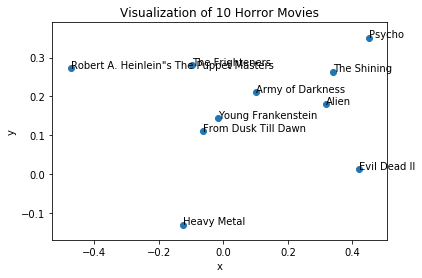

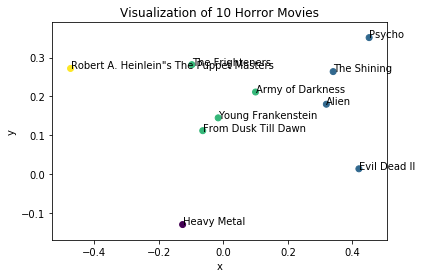

In [176]:
# Visualize 10 horror movies
horror = movies[movies['Horror'] == 1]['ID'].head(10)

for i in horror:
    print(movies[movies['ID'] == i]['Title'])
    
titles = ['From Dusk Till Dawn', 'Robert A. Heinlein"s The Puppet Masters', 'Heavy Metal', 'The Frighteners', 'Alien', 'Army of Darkness', 'Psycho', 'The Shining', 'Evil Dead II', 'Young Frankenstein']   
    
x = [0]*10
y = [0]*10
count = 0

for i in horror:
    x[count] = V_tilde[0][i-1]
    y[count] = V_tilde[1][i-1]
    count += 1
    
# clustering
X = np.column_stack((x, y))
labels = KMeans(n_clusters=4, random_state=0).fit_predict(X)

# plot visualization
fig, ax = plt.subplots()
plt.scatter(x, y)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Horror Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_3_d_3_.png')

# plot clusters
fig, ax = plt.subplots()
plt.scatter(x, y, c=labels)

for i, txt in enumerate(titles):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('Visualization of 10 Horror Movies')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('matrix_3_d_3_clusters.png')